# ML Project - Fall 2021  
---
Javad Hezare  
Ali Abbasi  
---
In this project, we are going to predict customers' behavior when clicking on an advertisement; whether they buy the product or not.

In [74]:
!pip install category_encoders
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
pd.options.mode.chained_assignment = None

Importing dataset:

In [75]:
df = pd.read_csv('https://github.com/a80-abbasi/ML_Project/blob/main/train_dataset.csv?raw=true')
# df = pd.read_csv('train_dataset.csv')
df.head()

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id
0,0,-1.0,-1,2020-08-04 04:07:56,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,-1,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC
1,0,-1.0,-1,2020-08-04 01:47:40,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,-1,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810
2,0,-1.0,-1,2020-08-04 16:54:31,-1,0.0,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,-1,-1,-1,-1,-1,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696
3,0,-1.0,-1,2020-08-03 20:34:28,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,-1,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6
4,0,-1.0,-1,2020-08-03 20:54:17,1064,0.0,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,-1,1B491180398E2F0390E6A588B3BCE291,9B57D98465FD7D5AF39448DC29E95DC8,13C26D10258053889D75D9B9CA922EC7,346AC0DECB71FFDC9114236B419D7814,1E629AECC2FB9BEF43331CBE8F2D7C08,341C9BD18A3277E6B104CAFC177DE796,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33


For better results, we seperate train set and validation set from the begining:

In [76]:
train_data, val_data = train_test_split(df, test_size=0.2)
train_data.shape, val_data.shape

((80000, 23), (20000, 23))

In [77]:
# for convenience
data = train_data

---
# 1. EDA, Data Cleaning and Feature Engineering

In this part we are going to get some insights about our data and find out what information each variable gives us and then, we start preparing our data for modeling by cleaning and deciding our policy for missing data. To do so we will follow bellow steps:
1. Understanding variables
2. Analyzing and Visualizing relationships between variables
3. Deciding what we should do with missing data
4. Choosing which features of data we are going to use to train our model

Inspecting datatypes of each feature:

In [78]:
data.dtypes

Sale                           int64
SalesAmountInEuro            float64
time_delay_for_conversion      int64
click_timestamp               object
nb_clicks_1week                int64
product_price                float64
product_age_group             object
device_type                   object
audience_id                   object
product_gender                object
product_brand                 object
product_category(1)           object
product_category(2)           object
product_category(3)           object
product_category(4)           object
product_category(5)           object
product_category(6)           object
product_category(7)            int64
product_country               object
product_id                    object
product_title                 object
partner_id                    object
user_id                       object
dtype: object

Columns with _object_ data type contain a hashed string.

With a little inspection we notice that _'click_timestamp'_ seem to contain only two dates:

In [79]:
# getting data part of click_timestamp
data['click_timestamp'].apply(lambda x: x.split(' ')[0]).unique()

array(['2020-08-04', '2020-08-03'], dtype=object)

We were right. So we can convert this column to 2 columns: one indicating the day and one indicating the number of seconds from the start of the day as integer values. But because _day_ value of these dates contains only two values, if we get a date other than these two in the test set, our model may have unpredictable behavior. And it seems a reasonable choice; time in a day can influence people decision of buying (or not buying) the product much more than which day they are in. So we only use _click seconds_:

In [80]:
def get_seconds(time_str):
  _, hour = time_str.split(' ')
  t = list(map(int, hour.split(':')))
  return t[0] * 3600 + t[1] * 60 + t[2]

# creating column click_seconds
data['click_second'] = data['click_timestamp'].apply(get_seconds)

In [81]:
# dropping click_timestamp column
data.drop(columns=['click_timestamp'], errors='ignore', inplace=True)
data.head()

,Sale,SalesAmountInEuro,time_delay_for_conversion,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id,click_second
96611,0,-1.0,-1,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,131E5010A476C9744E2075CB1CC17E0E,-1,AEA3CF80A8E52184841528BC5251A71A,BFF48FC0B6D9E62551E7BED5340E7916,69877
13194,0,-1.0,-1,66,0.0,4C90FD52FC53D2C1C205844CB69575AB,D7D1FB49049702BF6338894757E0D959,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,EFB1122EAF034D2671AE815ACFFC7B9E,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,-1,-1,-1,-1,-1,F0C08A161AA0404193A7EF78F5C3E06C,7C39A3A4434334AF4540E7396F160D31,1EB4F37DC106620AC6499E7D10F0E690 9C2363F33DC9E...,CC14152DD0806823ED88BA55D9A5240B,C50D6F63D0812026E9D55119DD7F2271,36634
58902,0,-1.0,-1,409,0.0,-1,FF2C446555E3822B0E0FC3406116E86D,-1,-1,0D989962AF75DFF7D579B2FFB9CCCA71,7532B3FBAFEC164460C4ED6FEB0C022C,FE4A86571601A1EF619CDB48BCD7F9A3,58D6D0E7760308F75E5FA67E03740C1E,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,6A0163065042DD153BE4987DC6B0BAA1,E81B4B9ABD03B8D1FDE7478A40367F9D AF24F32608196...,8B573DDAF7E0C5B6BE6195E737251064,5D2DFA90296912C702A386D1D1D74C75,72660
75063,0,-1.0,-1,166,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,4C8E310D7152DE70B060550D00CF9BD2,-1,B11F83250E97B9AE77366F23AD8D8567,7F286560861764CCB93C90B7AA833949,891EE660A73D9A6E1F4BD6149E613C44,0279CBF3081FFB710CE52B9E0BA4AABF,35A13FB2AB63E920B7D71C5957131606,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,1E458ADEFF2968AE82C51FEC92601259,616ECCB228546AE965263A89C50B77B3 B44908651DC5F...,6BFFDE668C5BC3938C875D3D0940E699,8F6415061DDB822A21F5B8B95C4BB361,27275
37502,0,-1.0,-1,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6CA1C3B2EF2011BCF281AA085370D386,7C7B76C0860076123E01C0D13F9D51B7,27625


For further examination, we split columns to 'numerical' and 'categorical' values:

In [82]:
target = 'Sale'
numerical_cols = ['click_second', 'nb_clicks_1week', 'product_price', 'SalesAmountInEuro', 'time_delay_for_conversion']
# getting left columns as categorical_columns
categorical_cols = list(set(data.columns) - set(numerical_cols) - set([target]))

Inspecting correlation matrix for numerical data:

In [83]:
data[[target] + numerical_cols].corr()

,Sale,click_second,nb_clicks_1week,product_price,SalesAmountInEuro,time_delay_for_conversion
Sale,1.000000,0.029373,-0.043810,0.418493,0.257800,0.451897
click_second,0.029373,1.000000,-0.028320,0.004628,0.003566,0.010424
nb_clicks_1week,-0.043810,-0.028320,1.000000,0.030323,-0.007193,-0.023884
product_price,0.418493,0.004628,0.030323,1.000000,0.377618,0.180574
SalesAmountInEuro,0.257800,0.003566,-0.007193,0.377618,1.000000,0.154534
time_delay_for_conversion,0.451897,0.010424,-0.023884,0.180574,0.154534,1.000000


Three of columns seem suspicious. _'SalesAmountInEuro'_, _'time_delay_for_conversion'_ and _'product_price'_ have relatively high value of correlation with _'Sale'_ and seem to have valid values whenever _'Sale'_ is one and vice versa. So we'd better examine them more closely and decide wether we should retain them or not. If our doubt is right, we should delete those columns and train our model on other columns. Otherwise, our model would be trained only on these columns and most probably do very terribly on test set.

In [84]:
# we'll use this function for evaluation of metrics: accuracy, precision, recall, and f1 of our models in the future
def print_metrics_evaluation(true_y, pred_y, model_name=None):
    if model_name is not None:
        print(f'{model_name}:')
    print(
f'''accuracy_score = {accuracy_score(true_y, pred_y)}
precision_score = {precision_score(true_y, pred_y)}
recall_score = {recall_score(true_y, pred_y)}
f1_score = {f1_score(true_y, pred_y)}
''')

We'll test our idea about these columns by predicting _'Sale'_ only based on these columns having valid values and print result metrics:

In [85]:
SalesAmountInEuro_predict = data['SalesAmountInEuro'] != -1
time_delay_for_conversion_predict = data['time_delay_for_conversion'] != -1
product_price_predict = data['product_price'] > 0
print_metrics_evaluation(data['Sale'], SalesAmountInEuro_predict, 'SalesAmountInEuro')
print_metrics_evaluation(data['Sale'], time_delay_for_conversion_predict, 'time_delay_for_conversion')
print_metrics_evaluation(product_price_predict, data['Sale'], 'product_price')

SalesAmountInEuro:
accuracy_score = 1.0
precision_score = 1.0
recall_score = 1.0
f1_score = 1.0

time_delay_for_conversion:
accuracy_score = 0.99945
precision_score = 1.0
recall_score = 0.9959890610756609
f1_score = 0.9979905005480454

product_price:
accuracy_score = 0.9912625
precision_score = 0.9362807657247038
recall_score = 1.0
f1_score = 0.9670919448236901



So for sure, we must drop those columns. They are almost equivalent to label (Sale) and we can't use them in training or our model will solely consider these columns:

In [86]:
# dropping named columns from dataframe and numerical columns:
dropping_columns = ['SalesAmountInEuro', 'time_delay_for_conversion', 'product_price']
data = data.drop(columns=dropping_columns, errors='ignore')

# for more convinece, we define a function for removing values from a list:
def remove_from_list(lst, value):
    value = value if isinstance(value, list) else [value]
    return list(set(lst).difference(value))

numerical_cols = remove_from_list(numerical_cols, dropping_columns)

Describing numerical columns:

In [87]:
data[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
click_second,80000.0,44581.484987,25528.284859,0.0,21294.0,47163.5,66798.25,86399.0
nb_clicks_1week,80000.0,239.283500,1162.385457,-1.0,-1.0,0.0,49.00,25390.0


As we can see the difference between 75% and max in _'nb_clicks_1week'_ is too much and it suggests that there must exist some outlier records in this column. But values in _'click_second'_ seem appropriately distributed.

Printing number of unique value in each column:  
These values will help us later with converting categorical values to their equivalent label (used for converting data to one hot) and deciding how many unique values to retain for each column.

In [88]:
data[categorical_cols].nunique(axis=0)

product_country           17
product_category(5)      422
product_category(4)      877
user_id                77897
partner_id               183
product_category(6)       84
product_category(1)       22
product_title          23593
product_category(7)        1
audience_id             2887
product_gender            11
product_id             38183
product_brand           4347
product_category(2)      143
product_age_group          9
product_category(3)      677
device_type                4
dtype: int64

As we can see, product_category(7) contains only one value, -1. It means non of our records have product_category(7) and we can drop it.

In [89]:
dropping_columns += ['product_category(7)']
data.drop(columns=dropping_columns, errors='ignore', inplace=True)
categorical_cols = remove_from_list(categorical_cols, dropping_columns)

Describing categorical columns:

In [90]:
data[categorical_cols].describe().T

,count,unique,top,freq
product_country,80000,17,57A1D462A03BD076E029CF9310C11FC5,30442
product_category(5),80000,422,-1,73565
product_category(4),80000,877,-1,56874
user_id,80000,77897,953CC020FA7459BC16D81E311EDF271E,35
partner_id,80000,183,E3DDEB04F8AFF944B11943BB57D2F620,24851
product_category(6),80000,84,-1,79076
product_category(1),80000,22,-1,36392
product_title,79791,23593,-1,36392
audience_id,80000,2887,-1,57535
product_gender,80000,11,-1,60418


Note that _'product_title'_ has nan values.  
We replace its nans with '-1' (it may seem strange but you'll know the reason when we decide our policy about missing values) and replace -1 in numerical values with nan:

In [91]:
data = data.replace({'product_title': np.nan}, '-1')
data[numerical_cols] = data[numerical_cols].replace(-1, np.nan)
data.head()

,Sale,nb_clicks_1week,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_country,product_id,product_title,partner_id,user_id,click_second
96611,0,NaN,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,131E5010A476C9744E2075CB1CC17E0E,-1,AEA3CF80A8E52184841528BC5251A71A,BFF48FC0B6D9E62551E7BED5340E7916,69877
13194,0,66.0,4C90FD52FC53D2C1C205844CB69575AB,D7D1FB49049702BF6338894757E0D959,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,EFB1122EAF034D2671AE815ACFFC7B9E,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,-1,-1,-1,-1,F0C08A161AA0404193A7EF78F5C3E06C,7C39A3A4434334AF4540E7396F160D31,1EB4F37DC106620AC6499E7D10F0E690 9C2363F33DC9E...,CC14152DD0806823ED88BA55D9A5240B,C50D6F63D0812026E9D55119DD7F2271,36634
58902,0,409.0,-1,FF2C446555E3822B0E0FC3406116E86D,-1,-1,0D989962AF75DFF7D579B2FFB9CCCA71,7532B3FBAFEC164460C4ED6FEB0C022C,FE4A86571601A1EF619CDB48BCD7F9A3,58D6D0E7760308F75E5FA67E03740C1E,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,6A0163065042DD153BE4987DC6B0BAA1,E81B4B9ABD03B8D1FDE7478A40367F9D AF24F32608196...,8B573DDAF7E0C5B6BE6195E737251064,5D2DFA90296912C702A386D1D1D74C75,72660
75063,0,166.0,-1,7E56C27BFF0305E788DA55A029EC4988,4C8E310D7152DE70B060550D00CF9BD2,-1,B11F83250E97B9AE77366F23AD8D8567,7F286560861764CCB93C90B7AA833949,891EE660A73D9A6E1F4BD6149E613C44,0279CBF3081FFB710CE52B9E0BA4AABF,35A13FB2AB63E920B7D71C5957131606,-1,-1,989EEF92F2A525DD896557425EA7C4C7,1E458ADEFF2968AE82C51FEC92601259,616ECCB228546AE965263A89C50B77B3 B44908651DC5F...,6BFFDE668C5BC3938C875D3D0940E699,8F6415061DDB822A21F5B8B95C4BB361,27275
37502,0,NaN,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6CA1C3B2EF2011BCF281AA085370D386,7C7B76C0860076123E01C0D13F9D51B7,27625


#### Dealing with outliers
For dealing with missing data, we should consider different methods for numerical and categorical columns.  
For numerical columns a simple boxplot can help alot.
Plotting boxplot for numerical values in order to find outliers:

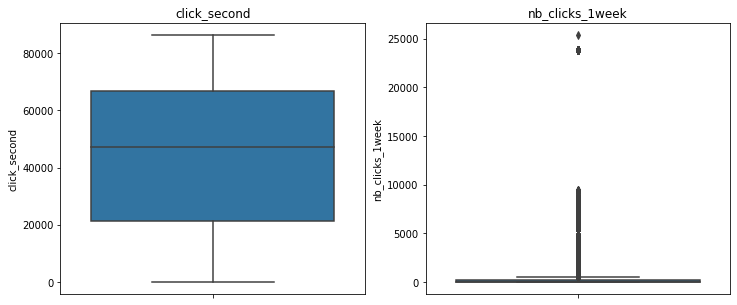

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for col, ax in zip(numerical_cols, axes.flatten()):
    ax.set_title(col)
    sns.boxplot(data=data, y=col, ax=ax)

As said, _'click_second'_ column have almost uniform distribution and its boxplot doesn't show any outlier. Butother plot suggests a very small range for non-outlier values for _'nb_clicks_1'_ week and if we remove outliers according to it, almost all of its values will be zero and we gain no information by using these features any more. So we choose to use 10000 for its upper limits respectively.

In [93]:
nb_click_threshold = 10000
data.loc[(data['nb_clicks_1week'] > nb_click_threshold), 'nb_clicks_1week'] = np.nan

We postpone dealing with categorical data outliers until examining their missing data.

#### Dealing with missing data
As observed, our dataset has lots of missing values and it definitely makes training our model very difficult. As you saw, there was columns like _'product_category(7)'_ which had only missing values! One usefull trick can be dropping columns and rows with too many missing values so that our model would be trained on a more valid data set and corropted rows/cells won't affect our model:   

In [94]:
print(data.shape)
data_with_null = data.replace('-1', np.nan)
col_threshold = 0.8
#Dropping categorical columns with missing value rate higher than threshold
dropping_columns += data_with_null.columns[data_with_null.isnull().mean() >= col_threshold].tolist()
data.drop(columns=dropping_columns, errors='ignore', inplace=True)
data_with_null.drop(columns=dropping_columns, errors='ignore', inplace=True)
categorical_cols = remove_from_list(categorical_cols, dropping_columns)
numerical_cols = remove_from_list(numerical_cols, dropping_columns)

row_threshold = 0.6
# #Dropping rows with missing value rate higher than threshold
data = data.loc[data_with_null.isnull().mean(axis=1) < row_threshold]
print(data.shape)

(80000, 19)
(60973, 17)


So this process droped $2$ columns and about $\frac{1}{4}$ of rows.  
Examining count of not null values in each column:

In [95]:
print(len(data))
data.replace('-1', np.nan).count().to_frame().set_axis(['count'], axis=1)

60973


,count
Sale,60973
nb_clicks_1week,43074
product_age_group,19535
device_type,60973
audience_id,16695
product_gender,19582
product_brand,27343
product_category(1),43608
product_category(2),43596
product_category(3),38156


Difference between count of rows in dataset and count of values in above is nothing other than missing values! Which deciding how to treat with them before going to training model is most important step in data cleaning.

Again, we consider different methods for numerical and categorical columns.  
For numerical data, we have to fill null values. We can consider two approaches for this purpose; filling them with the mean of corresponding columns and filling them with the median of their columns. But filling with median is a better choice in most cases. Because unlike mean that is affected by outliers, median is more robust against outliers.    
When it comes to dealing with missing values in categorical data, we have three options for replacing NaN values in categorical columns.  
1. Replacing them with the value that has maximum frequency in that column.  
2. Replacing them with the median of their columns.
3. Introducing a new category, e.g., 'other' for them.  
4. Using Target Encoder

For the second option, there should be an order between values and here we don't have any order (even in ordinal features like product_age_group, we can't deduce their order because of hashed strings). And because of the very high missing rate in our dataset, the first option doesn't seem very appropriate too.  
One good choice is using a combination of options 1 and 3; setting NaN values to the value that have maximum frequency in that column and creating another column that indicates if this is value was NaN initially or not.  
We are going to use option 3 for Deep Factorization Model and option 4 for XGBosst model.  
We will show option 3 here and option 4 will be implemented in pipelines at the end of this notebook.

Observing count of each unique value in each column:

In [96]:
# from IPython.display import display
# for col in data.columns:
#     display(data[col].value_counts().to_frame())

As you can see, some of columns have too many unique values and it is impossible for them to be converted to one hot vectors. We will convert some of values with low frequencies in these columns to 'other' category (the same category as NaNs) so that converting these columns to one hot encoder feasible. This is some kind of outlier removing too (as you can remember, we posponed dealing with categorical data outliers) because for example, there are values that has occured only once (or very few times) in more than 60000 rows, which can be produced due to data corruption or something like that. There are columns like _'user_id'_ and _'product_id'_ which have too many unique values with very low frequencies that suggest their presence cannot help predicting our target and of course we cannot convert them to one hot vectors with reasonable size that we decide to drop them.  
The reason that we retained '-1' values and even replaced nan values in categorical values with '-1' is that we wanted to use '-1' as class 'other' that you'll see here.


In [97]:
# dropping columns with unique values with low count:
dropping_columns += ['product_category(5)', 'product_category(6)', 'user_id', 'product_id']
data.drop(columns=dropping_columns, errors='ignore', inplace=True)
categorical_cols = remove_from_list(categorical_cols, dropping_columns)

In [98]:
# converting values with low frequency to other/nan
def delete_low_frequency(data, col, threshold):
    c = data[col]
    counts = c.value_counts()
    return c.replace(counts.index[counts < threshold], '-1')

# this dictionary is used for converting values with low frequencies in each column to 'other' class,
# values in this dictionary are minimum frequencies that we are going to retain
frequency_threshold = {
    'product_age_group': 100,
    'audience_id': 100,
    'product_gender': 1000,
    'product_brand': 150,
    'product_category(1)': 500,
    'product_category(2)': 500,
    'product_category(3)': 300,
    'product_category(4)': 250,
    'product_country': 100,
    'product_title': 50,
    'partner_id': 200
}

for col, freq in frequency_threshold.items():
    if col in data.columns:
        data[col] = delete_low_frequency(data, col, freq)

Now we map categorical values to integer values:

In [99]:
data[categorical_cols] = data[categorical_cols].astype('category')
column_categories = {}
for col in categorical_cols:
    column_categories[col] = data[col].cat.categories
    data[col] = data[col].cat.codes
# data = data.replace(-1, np.nan)

data.head()

,Sale,nb_clicks_1week,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_country,product_title,partner_id,click_second
96611,0,NaN,0,1,0,0,0,0,0,0,0,2,0,34,69877
13194,0,66.0,2,1,0,3,0,1,20,0,0,7,0,39,36634
58902,0,409.0,0,2,0,0,0,5,23,7,0,2,0,25,72660
75063,0,166.0,0,0,0,0,11,6,12,1,3,3,0,15,27275
74574,0,0.0,2,1,0,3,0,1,9,0,0,4,0,0,14326


We are not going to convert these values to one hot here. In our main model, i.e., Deep Factorization Model, the Embedding layer will convert them to one hot vectors it self.

If in test or validation sets there is a value for a column which is not in our categories, we will convert it to 'other' class. but if that column doesn't have 'other' class, we will replace mentioned value with mode of that column.

In [100]:
saved_modes = data.mode()

Filling numerical columns' NaN values with their median as it was mentioned before:

In [101]:
numerical_cols_medians = data[numerical_cols].median()
data[numerical_cols] = data[numerical_cols].fillna(numerical_cols_medians)

#### Normalizing data:
As you can know, we should not normalize value of category columns; specially if we are going to convert them to one hot vectors. So we only normalize numerical data:

In [102]:
saved_mean = data[numerical_cols].mean()
saved_std = data[numerical_cols].std()
data[numerical_cols] = (data[numerical_cols] - saved_mean) / saved_std
data

,Sale,nb_clicks_1week,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_country,product_title,partner_id,click_second
96611,0,-0.249462,0,1,0,0,0,0,0,0,0,2,0,34,1.003475
13194,0,-0.222510,2,1,0,3,0,1,20,0,0,7,0,39,-0.298235
58902,0,0.107646,0,2,0,0,0,5,23,7,0,2,0,25,1.112450
75063,0,-0.126255,0,0,0,0,11,6,12,1,3,3,0,15,-0.664709
74574,0,-0.286039,2,1,0,3,0,1,9,0,0,4,0,0,-1.171758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11920,0,-0.267751,2,0,0,1,0,8,14,0,0,1,0,27,-0.132403
29148,0,-0.279301,4,1,0,0,0,3,4,20,0,6,0,2,-1.230729
50345,0,-0.284114,2,0,0,1,0,8,0,0,0,1,0,27,-1.332264
93226,0,-0.283151,0,0,0,0,0,10,10,9,0,2,0,41,-1.730809


Generating final correlation matrix and its heatmap:

,Sale,nb_clicks_1week,click_second
nb_clicks_1week,-0.053798,1.000000,-0.048177
click_second,0.030495,-0.048177,1.000000
Sale,1.000000,-0.053798,0.030495


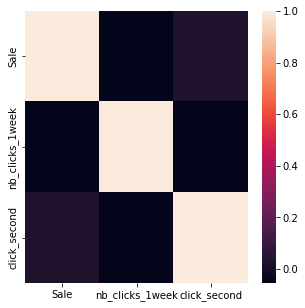

In [103]:
plt.figure(figsize = (5, 5))
correlation_matrix = data[[target] + numerical_cols].corr()
sns.heatmap(correlation_matrix)
correlation_matrix.sort_values('Sale')

The correlation of the remaining columns seems logical; neither too high like _'product_price'_ nor too low.

Reordering data as target - numerical columns - categorical columns:  
(Specially for Deep Factorization Model, this reordering is necessary. Because it treats numerical and categorical columns differently)

In [104]:
data = data[[target] + numerical_cols + categorical_cols]
data.head()

,Sale,nb_clicks_1week,click_second,product_country,device_type,audience_id,product_gender,product_category(4),product_brand,product_category(2),product_age_group,product_category(3),partner_id,product_category(1),product_title
96611,0,-0.249462,1.003475,2,1,0,0,0,0,0,0,0,34,0,0
13194,0,-0.222510,-0.298235,7,1,0,3,0,0,20,2,0,39,1,0
58902,0,0.107646,1.112450,2,2,0,0,0,0,23,0,7,25,5,0
75063,0,-0.126255,-0.664709,3,0,0,0,3,11,12,0,1,15,6,0
74574,0,-0.286039,-1.171758,4,1,0,3,0,0,9,2,0,0,1,0


For more convenience, we define a method that gets a dataframe and performs all above steps on it. This function will be helpfull for validating our validation (and of course, test) set.

In [105]:
TARGET_ENCODER = 'target_encoder'
OTHER = 'other'

def data_preprocess(data, dropping_columns, numerical_median, categories_mode, column_categories, saved_mean, saved_std, cleaning_type, ce=None):
    # convert 'click_timestamp' to 'click_second'
    data['click_second'] = data['click_timestamp'].apply(get_seconds)
    data = data.drop(columns=['click_timestamp'], errors='ignore')
    # drop columns
    data = data.drop(columns=dropping_columns, errors='ignore')

    # replace outliers with nan
    data.loc[(data['nb_clicks_1week'] > nb_click_threshold), 'nb_clicks_1week'] = np.nan
    # missing values:
    if cleaning_type == 'target_encoder':
        data = data.replace([-1, '-1'], np.nan).replace({'product_price': 0}, np.nan)
        for col in categorical_cols:
            data[f'{col}_is_na'] = data[col].isna() * 1
            data[col] = data[col].fillna(categories_mode[col])
        # encode categories
        data[categorical_cols] = ce.transform(data[categorical_cols])
        # removing columns with zero std
        data = data.drop(columns=dropping_columns, errors='ignore')
    elif cleaning_type == 'other':
        data = data.replace({'product_title': np.nan}, '-1')
        data[numerical_cols] = data[numerical_cols].replace(-1, np.nan)
        for col in categorical_cols:
            data[col] = pd.Categorical(data[col], column_categories[col]).codes
            cc = column_categories[col].tolist()
            data[col] = data[col].replace(-1, cc.index('-1') if '-1' in cc else categories_mode[col][0])
    data[numerical_cols] = data[numerical_cols].fillna(numerical_median)
    data[numerical_cols] = (data[numerical_cols] - saved_mean) / saved_std
    data = data[[target] +numerical_cols + categorical_cols]
    return data

# 2. Model Training

Now we will define different models and train them with our training set and evaluate our model with validation set.

In [ ]:
!pip install mlflow

# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import mlflow
import mlflow.pytorch
import pickle

from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

In [107]:
# for using GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Defining a simple Dataset class for our data used by pytorch models:

In [108]:
class SalePredictionDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i]

Because we are dealing with an imbalanced classification problem and our main metric is F1 score and True Positives are important to us, we give each class a weight and in our [pytorch] models, use them in BCE Loss Function to make model emphasis more on positive data.

In [109]:
class_weight = data[target].count() / data[target].value_counts()
class_weight = torch.tensor([class_weight[0], class_weight[1]])

Defining a pipeline-like structure for cleaning train and validation data more easily:

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class MyTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target, columns):
        self.columns = columns
        self.target = target
        self.encoders = {}

    def fit(self, df, y=None):
        for col in self.columns:
            ce = TargetEncoder()
            ce.fit(df[col], df[self.target])

            self.encoders[col] = ce

        return self
    
    def transform(self, df, y=None):
        for col in self.columns:
            df[col] = self.encoders[col].transform(df[col])
        return df[self.columns]

class Preproccess(BaseEstimator, TransformerMixin):
    def __init__(self, process_func, cleaning_type):
        self.process_func = process_func
        self.nb_click_threshold = 10000
        self.col_threshold = 0.8
        self.row_threshold = 0.7
        self.cleaning_type = cleaning_type
        self.dropping_columns = ['product_category(7)', 'product_category(5)', 'SalesAmountInEuro', 'product_category(6)', 'time_delay_for_conversion', 'product_price', 'user_id', 'product_id']
        self.categorical_cols = ['product_category(2)', 'product_title', 'device_type', 'product_category(1)', 'product_brand', 'product_gender', 'audience_id', 'product_category(4)', 'product_country', 'partner_id', 'product_category(3)', 'product_age_group']
        self.numercal_cols = ['click_second', 'nb_clicks_1week']

    def fit(self, df, y=None):
        print('-----[start fitting preproccessore transformer to data]-----')
        # convert 'click_timestamp' to 'click_second'
        df['click_second'] = df['click_timestamp'].apply(get_seconds)
        df = df.drop(columns=['click_timestamp'], errors='ignore')
        # drop columns
        df = df.drop(columns=self.dropping_columns, errors='ignore')
        # replace outliers with nan
        df.loc[(df['nb_clicks_1week'] > self.nb_click_threshold), 'nb_clicks_1week'] = np.nan
        categories_mode = df[self.categorical_cols].mode()
        ce = None
        column_categories = None
        if self.cleaning_type == 'target_encoder':
            ce = MyTargetEncoder('Sale', self.categorical_cols)
            df = df.replace([-1, '-1'], np.nan)
            # drop rows from df
            self.dropping_rows = df.isnull().mean(axis=1) > self.row_threshold
            df.drop(df.index[self.dropping_rows], errors='ignore', axis=0, inplace=True)
            for col in self.categorical_cols:
                df[f'{col}_is_na'] = df[col].isna() * 1
                df[col] = df[col].fillna(categories_mode[col])
            df[self.categorical_cols] = ce.fit_transform(df)
        elif self.cleaning_type == 'other':
            df = df.replace({'product_title': np.nan}, '-1')
            df[self.numercal_cols] = df[self.numercal_cols].replace(-1, np.nan)
            # drop rows from df
            self.dropping_rows = df.replace('-1', np.nan).isnull().mean(axis=1) > self.row_threshold
            for col, freq in frequency_threshold.items():
                if col in df.columns:
                    df[col] = delete_low_frequency(df, col, freq)
            df[self.categorical_cols] = df[self.categorical_cols].astype('category')
            column_categories = {}
            for col in self.categorical_cols:
                column_categories[col] = df[col].cat.categories
                df[col] = df[col].cat.codes
            categories_mode = df[self.categorical_cols].mode()

        # numerical columns median and categorical columns mode
        numerical_median = df[self.numercal_cols].median()
        df[self.numercal_cols] = df[self.numercal_cols].fillna(numerical_median)
        # save mean and std of columns
        saved_mean = df[self.numercal_cols].mean()
        saved_std = df[self.numercal_cols].std()

        # drop those columns with std = 0
        self.dropping_columns += df.columns[df.std() == 0].tolist()

        df[self.numercal_cols] = (df[self.numercal_cols] - saved_mean) / saved_std
        df = df[[target] +self.numercal_cols + self.categorical_cols]

        # saving parameters to use in transform
        self.ce = ce
        self.numerical_median = numerical_median
        self.categories_mode = categories_mode
        self.saved_mean = saved_mean
        self.saved_std = saved_std
        self.column_categories = column_categories
        
        print('-----[fitting transformer to data is done!]-----')
        return self

    def transform(self, df, y=None):
        return self.process_func(df, self.dropping_columns, self.numerical_median, self.categories_mode, self.column_categories, self.saved_mean, self.saved_std, self.cleaning_type, self.ce)

    def train_fit_transform(self, df, y=None):
        df = self.fit_transform(df)
        return df.drop(df.index[self.dropping_rows], errors='ignore', axis=0)

In [147]:
df = pd.read_csv('https://github.com/a80-abbasi/ML_Project/blob/main/train_dataset.csv?raw=true')
# df = pd.read_csv('train_dataset.csv')
train_data, val_data = train_test_split(df, test_size=0.2)

## 2.1. Pytorch Neural Network Model

We define a simple neural network model consisting multiple Linear layers, ReLU activation functions and Dropout for preventing overfitting on training data.  

In [37]:
class SalePrediction(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        #input
        self.input_size = input_size
        self.dropout = nn.Dropout(p=0.4)
        self.lnn = nn.Sequential(
            nn.Linear(self.input_size, 256),
            nn.ReLU(),
            self.dropout,
            nn.Linear(256, 128),
            nn.ReLU(),
            self.dropout,
            nn.Linear(128, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 32),
            nn.ReLU(),
            self.dropout,
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x: torch.tensor):
        x = x.view(-1, self.input_size)
        return self.lnn(x)

    def predict(self, x):
        return self.forward(x)

Creating Dataset and Dataloader from our training and validation data:

In [166]:
# for pickling processor
from pickle import load, dump

# creating function for getting dataloaders of train data and val data
def get_dataloaders(train_data, val_data,  batch_size=32):
    Y_train = train_data[target].to_numpy(dtype='float32')
    X_train = train_data.drop(columns=[target]).to_numpy(dtype='float32')
    Y_val = val_data[target].to_numpy(dtype='float32')
    X_val = val_data.drop(columns=[target], errors='ignore').to_numpy(dtype='float32')
    train_set = SalePredictionDataset(X_train, Y_train)
    val_set = SalePredictionDataset(X_val, Y_val)
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

preprocessor = Preproccess(data_preprocess, OTHER)
processed_train = preprocessor.fit_transform(train_data)
processed_val = preprocessor.transform(val_data)
dump(preprocessor, open('other_preprocessor.pkl', 'wb'))
train_loader, val_loader = get_dataloaders(processed_train, processed_val, 32)

Creating train and validate functions for more convenience.  
Note how we used class weights in BCELoss in order to get a better F1 score:

In [167]:
def train(model, optimizer, epoch):
    train_loss = 0
    N_train = len(train_loader.dataset)

    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.view(-1, 1).to(device)
            p = model(x)
            
            # Weighted BCELoss, punishing wrong prediction of true label more heavily
            criterion = nn.BCELoss(weight=torch.tensor([class_weight[val] for val in y.to(torch.long)]).view(-1, 1)).to(device)
            loss = criterion(p, y)
            train_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Train Loss: {train_loss / N_train:.3e}')
            
            loss.backward()
            optimizer.step()
    
    train_loss /= N_train
    mlflow.log_metric('train_loss', train_loss)
    return train_loss


def validate(model, epoch):
    val_loss = 0
    N_val = len(val_loader.dataset)

    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.view(-1, 1).to(device)
            p = model(x)

            criterion = nn.BCELoss(weight=torch.tensor([class_weight[val] for val in y.to(torch.long)]).view(-1, 1)).to(device)
            loss = criterion(p, y)
            val_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Val Loss: {val_loss / N_val:.3e}')
    
    print('-------------------------------------------------------------------')
    val_loss /= N_val
    mlflow.log_metric('val_loss', val_loss)
    return val_loss

This function trians given pytorch model and returns the best result of training process, plots learning curves for train and validation sets and finally prints metrics' values. Also this function tracks and logs hyperparameters, learning curves and model it self with MLFlow.

In [168]:
def do_expriment(model, optimizer, num_epochs, model_name, threshold=0.5):

    train_loss_arr, val_loss_arr = np.zeros(num_epochs), np.zeros(num_epochs)

    with mlflow.start_run():
        mlflow.log_param('learning_rate', lr)
        mlflow.log_param('num_epochs', num_epochs)
        
        val_loss_min = float('inf')

        for epoch in range(num_epochs):
            train_loss = train(model, optimizer, epoch)
            val_loss = validate(model, epoch)

            train_loss_arr[epoch] = train_loss
            val_loss_arr[epoch] = val_loss

            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), f'{model_name}.pt')
                val_loss_min = val_loss

        # load best model during different epochs
        model.load_state_dict(torch.load(f'{model_name}.pt'))

        # log trained model
        print("\nLogging the trained model as a run artifact...")
        mlflow.pytorch.log_model(model, artifact_path="pytorch-model", pickle_module=pickle)
        print('Logging the trained model is done')

        # metrics
        X_train, Y_train = train_loader.dataset[:]
        X_val, Y_val = val_loader.dataset[:]

        model = model.to('cpu')

        train_preds = model(X_train).view(-1) >= 0
        val_preds = model(X_val).view(-1) >= 0

        mlflow.log_metric('Train Precision', precision_score(Y_train, train_preds, average='macro'))
        mlflow.log_metric('Train Recall' ,recall_score(Y_train, train_preds, average='macro'))
        mlflow.log_metric('Train F1Score', f1_score(Y_train, train_preds))

        mlflow.log_metric('val Precision', precision_score(Y_val, val_preds, average='macro'))
        mlflow.log_metric('val Recall', recall_score(Y_val, val_preds, average='macro'))
        mlflow.log_metric('val F1Score', f1_score(Y_val, val_preds))

        plt.plot(train_loss_arr, label='train')
        plt.plot(val_loss_arr, label='val')
        plt.legend();

        print_metrics_evaluation(Y_train.view(-1).detach(), model(X_train).view(-1).detach() >= threshold, f'{model_name}: Metrics on Training Data')
        print_metrics_evaluation(Y_val.view(-1).detach(), model(X_val).view(-1).detach() >= threshold, f'{model_name}: Metrics on Validation Data')

        model = model.to(device)

        return train_loss_arr, val_loss_arr, model

Epoch:0, Val Loss: 1.355e+00: 100%|██████████| 625/625 [00:04<00:00, 147.19it/s]


-------------------------------------------------------------------


Epoch:1, Val Loss: 1.339e+00: 100%|██████████| 625/625 [00:04<00:00, 149.88it/s]


-------------------------------------------------------------------


Epoch:2, Val Loss: 1.331e+00: 100%|██████████| 625/625 [00:04<00:00, 147.78it/s]


-------------------------------------------------------------------


Epoch:3, Val Loss: 1.327e+00: 100%|██████████| 625/625 [00:04<00:00, 146.11it/s]


-------------------------------------------------------------------


Epoch:4, Val Loss: 1.321e+00: 100%|██████████| 625/625 [00:04<00:00, 149.50it/s]


-------------------------------------------------------------------


Epoch:5, Val Loss: 1.318e+00: 100%|██████████| 625/625 [00:04<00:00, 148.51it/s]


-------------------------------------------------------------------


Epoch:6, Val Loss: 1.316e+00: 100%|██████████| 625/625 [00:04<00:00, 146.62it/s]


-------------------------------------------------------------------


Epoch:7, Val Loss: 1.313e+00: 100%|██████████| 625/625 [00:04<00:00, 148.55it/s]


-------------------------------------------------------------------


Epoch:8, Val Loss: 1.312e+00: 100%|██████████| 625/625 [00:04<00:00, 148.55it/s]


-------------------------------------------------------------------


Epoch:9, Val Loss: 1.309e+00: 100%|██████████| 625/625 [00:04<00:00, 144.95it/s]


-------------------------------------------------------------------


Epoch:10, Val Loss: 1.310e+00: 100%|██████████| 625/625 [00:04<00:00, 145.48it/s]


-------------------------------------------------------------------


Epoch:11, Val Loss: 1.308e+00: 100%|██████████| 625/625 [00:04<00:00, 147.18it/s]


-------------------------------------------------------------------


Epoch:12, Val Loss: 1.314e+00: 100%|██████████| 625/625 [00:04<00:00, 145.98it/s]


-------------------------------------------------------------------


Epoch:13, Val Loss: 1.308e+00: 100%|██████████| 625/625 [00:04<00:00, 144.81it/s]


-------------------------------------------------------------------


Epoch:14, Val Loss: 1.309e+00: 100%|██████████| 625/625 [00:04<00:00, 145.97it/s]


-------------------------------------------------------------------


Epoch:15, Val Loss: 1.304e+00: 100%|██████████| 625/625 [00:04<00:00, 146.89it/s]


-------------------------------------------------------------------


Epoch:16, Val Loss: 1.315e+00: 100%|██████████| 625/625 [00:04<00:00, 146.32it/s]


-------------------------------------------------------------------


Epoch:17, Val Loss: 1.309e+00: 100%|██████████| 625/625 [00:04<00:00, 145.58it/s]


-------------------------------------------------------------------


Epoch:18, Val Loss: 1.311e+00: 100%|██████████| 625/625 [00:04<00:00, 145.45it/s]


-------------------------------------------------------------------


Epoch:19, Val Loss: 1.309e+00: 100%|██████████| 625/625 [00:04<00:00, 145.19it/s]


-------------------------------------------------------------------


Epoch:20, Val Loss: 1.307e+00: 100%|██████████| 625/625 [00:04<00:00, 143.05it/s]


-------------------------------------------------------------------


Epoch:21, Val Loss: 1.305e+00: 100%|██████████| 625/625 [00:04<00:00, 145.22it/s]


-------------------------------------------------------------------


Epoch:22, Val Loss: 1.313e+00: 100%|██████████| 625/625 [00:04<00:00, 142.57it/s]


-------------------------------------------------------------------


Epoch:23, Val Loss: 1.307e+00: 100%|██████████| 625/625 [00:04<00:00, 141.67it/s]


-------------------------------------------------------------------


Epoch:24, Val Loss: 1.305e+00: 100%|██████████| 625/625 [00:04<00:00, 142.10it/s]


-------------------------------------------------------------------


Epoch:25, Val Loss: 1.309e+00: 100%|██████████| 625/625 [00:04<00:00, 142.68it/s]


-------------------------------------------------------------------


Epoch:26, Val Loss: 1.306e+00: 100%|██████████| 625/625 [00:04<00:00, 144.21it/s]


-------------------------------------------------------------------


Epoch:27, Val Loss: 1.308e+00: 100%|██████████| 625/625 [00:04<00:00, 142.73it/s]


-------------------------------------------------------------------


Epoch:28, Val Loss: 1.299e+00: 100%|██████████| 625/625 [00:04<00:00, 142.80it/s]


-------------------------------------------------------------------


Epoch:29, Val Loss: 1.303e+00: 100%|██████████| 625/625 [00:04<00:00, 143.13it/s]
2022/02/09 01:33:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


-------------------------------------------------------------------

Logging the trained model as a run artifact...


2022/02/09 01:33:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzh2qt89l/model/data, flavor: pytorch), fall back to return ['torch==1.10.0', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.


Logging the trained model is done


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NNModel1: Metrics on Training Data:
accuracy_score = 0.6130334865397242
precision_score = 0.2114649199197304
recall_score = 0.6702268090723629
f1_score = 0.32149435873819937

NNModel1: Metrics on Validation Data:
accuracy_score = 0.60105
precision_score = 0.20082295119442223
recall_score = 0.6403061224489796
f1_score = 0.30575132689463147



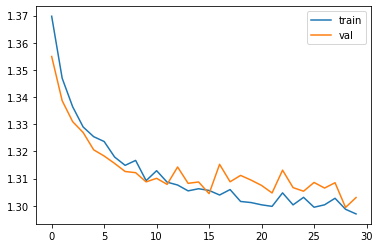

In [45]:
model = SalePrediction(data.shape[1] - 1).to(device)
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_arr, val_loss_arr, model = do_expriment(model, optimizer, num_epochs=30, model_name='NNModel1', threshold=0.5)

## 2.2. TensorFlow

Simple Neural Network Model implented via Tensorflow. It is much like above model but tensorflow has a much simpler process of training.  
Their only difference is that our Tensorflow model use Target Encoding to encode categorical data:

In [159]:
import mlflow.tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.constraints import maxnorm

In [160]:
model = Sequential([
    Dense(60, activation='relu', kernel_constraint=maxnorm(3)),
    Dense(60, activation='relu', kernel_constraint=maxnorm(3)),
    Dense(60, activation='relu', kernel_constraint=maxnorm(3)),
    Dense(30, activation='relu', kernel_constraint=maxnorm(3)),
    Dense(1, activation='sigmoid')
])

model.compile(
    # loss='binary_focal_crossentropy',
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['TruePositives']
)

In [161]:
preprocessor = Preproccess(data_preprocess, TARGET_ENCODER)
processed_train = preprocessor.fit_transform(train_data)
processed_val = preprocessor.transform(val_data)

X_train = processed_train.drop(columns=[target], errors='ignore').astype('float32')
Y_train = processed_train[target].astype('float32')
X_val = processed_val.drop(columns=[target], errors='ignore').astype('float32')
Y_val = processed_val['Sale'].astype('float32')

-----[start fitting preproccessore transformer to data]-----
-----[fitting transformer to data is done!]-----


In [162]:
# mlflow.set_experiment('TensorflowModel')

with mlflow.start_run():
  mlflow.tensorflow.autolog()
  
  model.fit(
      X_train,
      Y_train,
      batch_size=64,
      epochs=30,
      validation_data=(X_val, Y_val),
      class_weight={0:0.1, 1:0.9}
  )

2022/02/09 07:28:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


Epoch 1/30
1250/1250 [==============================] - 9s 6ms/step - loss: 0.1298 - true_positives: 10328.0000 - val_loss: 0.6974 - val_true_positives: 1848.0000
Epoch 2/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1136 - true_positives: 9260.0000 - val_loss: 0.7157 - val_true_positives: 1957.0000
Epoch 3/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1103 - true_positives: 9350.0000 - val_loss: 0.7589 - val_true_positives: 2146.0000
Epoch 4/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1084 - true_positives: 9425.0000 - val_loss: 0.7714 - val_true_positives: 2166.0000
Epoch 5/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1074 - true_positives: 9474.0000 - val_loss: 0.7016 - val_true_positives: 1999.0000
Epoch 6/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1067 - true_positives: 9516.0000 - val_loss: 0.6725 - val_true_positives: 1790.0000
Epoch 7/30
1250/1250 [=====

2022/02/09 07:32:26 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.1.71+cuda111) contains a local version label (+cuda111). MLflow logged a pip requirement for this package as 'jaxlib==0.1.71' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [163]:
train_predict = model.predict(X_train) >= 0.5
val_predict = model.predict(X_val) >= 0.5

In [164]:
print_metrics_evaluation(Y_train, train_predict)
print_metrics_evaluation(Y_val, val_predict)

accuracy_score = 0.5432125
precision_score = 0.22291860944243239
recall_score = 0.935304822565969
f1_score = 0.3600287210381604

accuracy_score = 0.4823
precision_score = 0.18043424007986025
recall_score = 0.812055409958817
f1_score = 0.2952627280152464



## 2.3 XGBoost  
XGBoost is a Desicion-Tree based model which benefits from ensembles and gradient boosting:

In [148]:
import xgboost as xgb

In [155]:
preprocessor = Preproccess(data_preprocess, TARGET_ENCODER)
processed_train = preprocessor.train_fit_transform(train_data)
processed_val = preprocessor.transform(val_data)

X_train = processed_train.drop(columns=[target], errors='ignore').astype('float32')
Y_train = processed_train[target].astype('float32')
X_val = processed_val.drop(columns=[target], errors='ignore').astype('float32')
Y_val = processed_val['Sale'].astype('float32')

D_train = xgb.DMatrix(X_train, label=Y_train)
D_val = xgb.DMatrix(X_val, label=Y_val)

-----[start fitting preproccessore transformer to data]-----
-----[fitting transformer to data is done!]-----


In [156]:
param = {
    'eta': 0.3,
    'max_depth': 4,
    'objective': 'binary:logitraw'
}

step = 20

In [157]:
model = xgb.train(param, D_train, step)

In [158]:
train_preds = model.predict(D_train) > 0
val_preds = model.predict(D_val) > 0

print_metrics_evaluation(Y_train, train_preds)
print_metrics_evaluation(Y_val, val_preds)

accuracy_score = 0.8765709156193896
precision_score = 0.7078891257995735
recall_score = 0.21146496815286625
f1_score = 0.32564982834722905

accuracy_score = 0.86065
precision_score = 0.37815126050420167
recall_score = 0.06739049045301385
f1_score = 0.11439466158245949



## 2.4. Deep Factorization

And finally, Deep Factorization Model is going to be our main model. Because of its Embedding layer, it is able to learn mixed affect of different features on the target and is most easy to use for categorical data, without need to convert them to one hot vector and does it itself internally.  
For mentioned reasons and of course for better f1 score, we are going to use Deep Factorization Model as our main model.  
Our architecture for this model is similar as below's:

<img src="https://d2l.ai/_images/rec-deepfm.svg">

In [169]:
class DeepFactorization(nn.Module):
    def __init__(self, category_dims, MLP_dims, numerical_dim, embed_vector_size = 8):
        super().__init__()
        self.numerical_dim = numerical_dim
        sum_category_dims = sum(category_dims)
        self.embedding = nn.Embedding(sum_category_dims, embed_vector_size)
        linear_size = len(category_dims) * embed_vector_size + numerical_dim
        self.FM = nn.Sequential(nn.Linear(linear_size, 1), nn.ReLU())
        linear_layers = []
        for output_size in MLP_dims:
            linear_layers.extend([
                nn.Linear(linear_size, output_size),
                nn.ReLU(),
                nn.Dropout(0.2)])
            linear_size = output_size
        linear_layers.append(nn.Linear(linear_size, 1))
        self.MLP = nn.Sequential(*linear_layers)
        self.Flatten = nn.Flatten()
        self.Sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x_n = x[:, :self.numerical_dim]
        x_c = x[:, self.numerical_dim:].to(torch.int32)
        embed_x_c = self.embedding(x_c)
        flatten_embed = self.Flatten(embed_x_c)
        square_of_sum = torch.sum(embed_x_c, axis=1) ** 2
        sum_of_square = torch.sum(embed_x_c ** 2, axis=1)
        linear_input = torch.cat((flatten_embed, x_n), dim=-1)
        # TODO: linear_input or flatten_embed to FM?
        output = self.FM(linear_input) + self.MLP(linear_input) \
                 + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        return self.Sigmoid(output)

    def predict(self, x):
        return self.forward(x)

In [170]:
numerical_dim = len(numerical_cols)
category_dims = [len(column_categories[col]) for col in categorical_cols]
MLP_dims = [2000, 1000, 500, 256, 128, 64, 32, 16, 8]
model = DeepFactorization(category_dims, MLP_dims, numerical_dim).to(device)

criterion = nn.BCELoss().to(device)
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
model

DeepFactorization(
  (embedding): Embedding(212, 8)
  (FM): Sequential(
    (0): Linear(in_features=98, out_features=1, bias=True)
    (1): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=98, out_features=2000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2000, out_features=1000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1000, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=500, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=128, out_features=64, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.2, inplace=False

Epoch:0, Val Loss: 3.596e+00: 100%|██████████| 625/625 [00:05<00:00, 116.92it/s]


-------------------------------------------------------------------


Epoch:1, Val Loss: 1.743e+00: 100%|██████████| 625/625 [00:05<00:00, 117.20it/s]


-------------------------------------------------------------------


Epoch:2, Val Loss: 1.534e+00: 100%|██████████| 625/625 [00:05<00:00, 113.13it/s]


-------------------------------------------------------------------


Epoch:3, Val Loss: 1.365e+00: 100%|██████████| 625/625 [00:05<00:00, 113.88it/s]


-------------------------------------------------------------------


Epoch:4, Val Loss: 1.350e+00: 100%|██████████| 625/625 [00:05<00:00, 113.42it/s]


-------------------------------------------------------------------


Epoch:5, Val Loss: 1.302e+00: 100%|██████████| 625/625 [00:05<00:00, 113.50it/s]


-------------------------------------------------------------------


Epoch:6, Val Loss: 1.299e+00: 100%|██████████| 625/625 [00:05<00:00, 115.13it/s]


-------------------------------------------------------------------


Epoch:7, Val Loss: 1.273e+00: 100%|██████████| 625/625 [00:05<00:00, 111.59it/s]


-------------------------------------------------------------------


Epoch:8, Val Loss: 1.279e+00: 100%|██████████| 625/625 [00:05<00:00, 116.36it/s]


-------------------------------------------------------------------


Epoch:9, Val Loss: 1.270e+00: 100%|██████████| 625/625 [00:05<00:00, 115.39it/s]


-------------------------------------------------------------------


Epoch:10, Val Loss: 1.296e+00: 100%|██████████| 625/625 [00:05<00:00, 115.49it/s]


-------------------------------------------------------------------


Epoch:11, Val Loss: 1.282e+00: 100%|██████████| 625/625 [00:05<00:00, 115.59it/s]


-------------------------------------------------------------------


Epoch:12, Val Loss: 1.268e+00: 100%|██████████| 625/625 [00:05<00:00, 117.29it/s]


-------------------------------------------------------------------


Epoch:13, Val Loss: 1.257e+00: 100%|██████████| 625/625 [00:05<00:00, 117.27it/s]


-------------------------------------------------------------------


Epoch:14, Val Loss: 1.248e+00: 100%|██████████| 625/625 [00:05<00:00, 115.31it/s]


-------------------------------------------------------------------


Epoch:15, Val Loss: 1.256e+00: 100%|██████████| 625/625 [00:05<00:00, 115.95it/s]


-------------------------------------------------------------------


Epoch:16, Val Loss: 1.257e+00: 100%|██████████| 625/625 [00:05<00:00, 115.39it/s]


-------------------------------------------------------------------


Epoch:17, Val Loss: 1.256e+00: 100%|██████████| 625/625 [00:05<00:00, 117.19it/s]


-------------------------------------------------------------------


Epoch:18, Val Loss: 1.262e+00: 100%|██████████| 625/625 [00:05<00:00, 114.75it/s]


-------------------------------------------------------------------


Epoch:19, Val Loss: 1.264e+00: 100%|██████████| 625/625 [00:05<00:00, 115.53it/s]


-------------------------------------------------------------------


Epoch:20, Val Loss: 1.256e+00: 100%|██████████| 625/625 [00:05<00:00, 114.12it/s]


-------------------------------------------------------------------


Epoch:21, Val Loss: 1.281e+00: 100%|██████████| 625/625 [00:05<00:00, 116.36it/s]


-------------------------------------------------------------------


Epoch:22, Val Loss: 1.327e+00: 100%|██████████| 625/625 [00:05<00:00, 112.71it/s]


-------------------------------------------------------------------


Epoch:23, Val Loss: 1.323e+00: 100%|██████████| 625/625 [00:05<00:00, 112.95it/s]


-------------------------------------------------------------------


Epoch:24, Val Loss: 1.293e+00: 100%|██████████| 625/625 [00:05<00:00, 113.10it/s]


-------------------------------------------------------------------


Epoch:25, Val Loss: 1.277e+00: 100%|██████████| 625/625 [00:05<00:00, 110.21it/s]


-------------------------------------------------------------------


Epoch:26, Val Loss: 1.342e+00: 100%|██████████| 625/625 [00:05<00:00, 111.66it/s]


-------------------------------------------------------------------


Epoch:27, Val Loss: 1.314e+00: 100%|██████████| 625/625 [00:05<00:00, 111.69it/s]


-------------------------------------------------------------------


Epoch:28, Val Loss: 1.260e+00: 100%|██████████| 625/625 [00:05<00:00, 113.47it/s]


-------------------------------------------------------------------


Epoch:29, Val Loss: 1.256e+00: 100%|██████████| 625/625 [00:05<00:00, 113.24it/s]


-------------------------------------------------------------------


Epoch:30, Val Loss: 1.246e+00: 100%|██████████| 625/625 [00:05<00:00, 114.11it/s]


-------------------------------------------------------------------


Epoch:31, Val Loss: 1.247e+00: 100%|██████████| 625/625 [00:05<00:00, 114.11it/s]


-------------------------------------------------------------------


Epoch:32, Val Loss: 1.252e+00: 100%|██████████| 625/625 [00:05<00:00, 112.50it/s]


-------------------------------------------------------------------


Epoch:33, Val Loss: 1.247e+00: 100%|██████████| 625/625 [00:05<00:00, 112.87it/s]


-------------------------------------------------------------------


Epoch:34, Val Loss: 1.248e+00: 100%|██████████| 625/625 [00:05<00:00, 112.60it/s]


-------------------------------------------------------------------


Epoch:35, Val Loss: 1.255e+00: 100%|██████████| 625/625 [00:05<00:00, 113.45it/s]


-------------------------------------------------------------------


Epoch:36, Val Loss: 1.293e+00: 100%|██████████| 625/625 [00:05<00:00, 111.95it/s]


-------------------------------------------------------------------


Epoch:37, Val Loss: 1.260e+00: 100%|██████████| 625/625 [00:05<00:00, 112.21it/s]


-------------------------------------------------------------------


Epoch:38, Val Loss: 1.321e+00: 100%|██████████| 625/625 [00:05<00:00, 112.93it/s]


-------------------------------------------------------------------


Epoch:39, Val Loss: 1.261e+00: 100%|██████████| 625/625 [00:05<00:00, 112.45it/s]
2022/02/09 07:59:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


-------------------------------------------------------------------

Logging the trained model as a run artifact...


2022/02/09 07:59:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmf0leuah/model/data, flavor: pytorch), fall back to return ['torch==1.10.0', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.


Logging the trained model is done


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DeepFactorization: Metrics on Training Data:
accuracy_score = 0.6380529086644908
precision_score = 0.23178677971424086
recall_score = 0.7027252171843389
f1_score = 0.3485935240119248

DeepFactorization: Metrics on Validation Data:
accuracy_score = 0.59465
precision_score = 0.20105587329520458
recall_score = 0.6843878697117185
f1_score = 0.3108050667346765



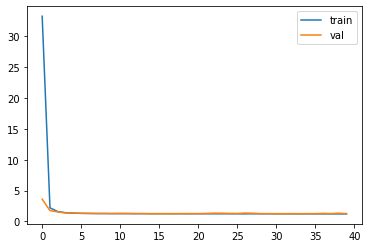

In [171]:
train_loss_arr, val_loss_arr, model = do_expriment(model, optimizer, num_epochs=40, model_name='DeepFactorization', threshold=0.5)

As you can see, we achived our best result (best f1 score) with our deep factorization model. Its f1 score on validation set is almost as good as on training set. For weakness of model, we can mention its low precision score. The reason behind this low metric is that our model generates positive results more than it should and it is so because we have given different weights to positive and negative calss and it punishes positve misclassifications more than negative misclassifications and our model tries to minimize its FNs with generating more positive rewards.


Using a pipeline-like structure for training of our models:

In [44]:
class Model(BaseEstimator, TransformerMixin):
    def __init__(self, model, model_name, target='Sale', num_epochs=30, lr=1e-4):
        self.model = model
        self.model_name = model_name
        self.target = target
        self.num_epochs = num_epochs
        self.lr = lr
        self.train_func
    
    def fit(self, df, y=None):
        # model, optimizer, num_epochs, model_name, threshold=0.5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        _, _, self.model = do_expriment(self.model, optimizer, self.num_epochs, self.model_name, 0.5)
        return self

    def transform(self, df, y=None):
        X = torch.from_numpy(df.drop(columns=[target]).to_numpy(dtype=np.float32)).to(device)
        return self.model(X)

# 4. Deployment

Now we can serve our pickled model during training process with following command:

In [174]:
!mlflow models serve -m '/content/mlruns/1/f5eac64da126407aba7da0876367335f/artifacts/model' --no-conda -p 1234

2022/02/09 08:29:45 INFO mlflow.models.cli: Selected backend for flavor 'python_function'
2022/02/09 08:29:45 INFO mlflow.pyfunc.backend: === Running command 'gunicorn --timeout=60 -b 127.0.0.1:1234 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2022-02-09 08:29:46 +0000] [1461] [INFO] Starting gunicorn 20.1.0
[2022-02-09 08:29:46 +0000] [1461] [INFO] Listening at: http://127.0.0.1:1234 (1461)
[2022-02-09 08:29:46 +0000] [1461] [INFO] Using worker: sync
[2022-02-09 08:29:46 +0000] [1464] [INFO] Booting worker with pid: 1464
/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-02-09 08:29:56.366077: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39

And get model's prediction for test set data as follow:

In [ ]:
import requests
# set DATA_PATH for your test dataset
DATA_PATH = 'https://github.com/a80-abbasi/ML_Project/blob/main/train_dataset.csv?raw=true'
HOST = '127.0.0.1'
PORT = 8080
URL = f'http://{HOST}:{PORT}/invocations'
header = {
    'Content-Type': 'application/json',
}
data = pd.read_csv(DATA_PATH)
# load preproceesor object
preprocessor = load(open('other_preprocessor.pkl', 'rb'))
processed_data = preprocessor.transform(data)
# set your test batch
test_data = processed_data.loc[20:30, :]

json = test_data.to_json(orient='split')

r = requests.post(url=URL, headers=header, data=json)

print(f'Predictions: {r.text}')

In [ ]:
# for downloading mlruns folder from colab
# !zip -r mlruns.zip ./mlruns/